In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker

### Part 2: Exploratory Data Analysis
Using your scraped data, investigates different relationships between candidates and the amount of money they raised. Here are some suggestions to get you started, but feel free to pose you own questions or do additional exploration:  
    a. How often does the candidate who raised more money win a race?  
    b. How often does the candidate who spent more money win a race?  
    c. Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?  
    d. How often does the incumbent candidate win a race?  
    e. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

In [3]:
os.chdir('..')
print(f'current working directory is {os.getcwd()}')

current working directory is C:\Users\lexil\Documents\NSS_Projects\open-secrets-three-musketeers


In [4]:
full_df = pd.read_csv('../open-secrets-three-musketeers/data/full_df.csv')

In [5]:
df_dropped_columns = full_df.drop(columns=['Incumbent', 'IncCID', 'capeye', 'SmLgIndivsNote', 'DistIDCurr', 'PACs', 'Indivs', 'Cand', 'Other', 'ReleaseDate', 'enddate'])

In [6]:
df_clean = df_dropped_columns.rename(columns={'Rcpts': 'Money_Raised', 'Spent': 'Money_Spent', 'CRPICO': 'Candidate_Type'})

How often does the candidate who raised more money win a race?

would we loop through wins over losses in a specific district and then calculate the probability?

In [8]:
df_clean['Result'] = df_clean['Result'].replace(r'^\s*$', np.nan, regex=True).replace(0, np.nan)
df_clean = df_clean.dropna()
df_clean

,cid,FirstLastP,Money_Raised,Money_Spent,EndCash,LgIndivs,SmIndivs,VotePercent,Result,Candidate_Type,State,primarydate,sort,District,State_Abv
0,N00044245,Jerry Carl (R),1971321.50,1859348.91,111972.59,999616.34,44579.61,64.88,W,O,Alabama,2020-03-03 00:00:00 +0000,2,1,AL
1,N00044750,James Averhart (D),80094.95,78973.24,1121.71,37954.77,12895.18,35.04,L,O,Alabama,2020-03-03 00:00:00 +0000,2,1,AL
2,N00041295,Barry Moore (R),650806.75,669367.70,-13633.28,346328.65,62207.55,65.30,W,O,Alabama,2020-03-03 00:00:00 +0000,2,2,AL
3,N00045944,Phyllis Harvey-Hall (D),56049.68,55988.07,0.00,27105.15,15306.80,34.61,L,O,Alabama,2020-03-03 00:00:00 +0000,2,2,AL
5,N00024759,Mike D Rogers (R),1193111.43,1218563.76,502233.70,438054.00,5315.00,67.54,W,I,Alabama,2020-03-03 00:00:00 +0000,1,3,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,N00045620,Tricia Zunker (D),1261957.30,1232690.26,29267.04,566859.76,600014.91,39.24,L,C,Wisconsin,2020-08-11 00:00:00 +0000,2,7,WI
1257,N00039330,Mike Gallagher (R),3202904.74,2841800.71,1169361.53,2040298.63,188430.08,63.98,W,I,Wisconsin,2020-08-11 00:00:00 +0000,1,8,WI
1258,N00045078,Amanda Stuck (D),416978.45,399915.94,2164.80,221453.03,169379.57,36.02,L,C,Wisconsin,2020-08-11 00:00:00 +0000,2,8,WI
1259,N00035504,Liz Cheney (R),3003883.34,3060166.78,153567.15,980348.72,189646.74,68.60,W,I,Wyoming,2020-08-18 00:00:00 +0000,1,1,WY


In [9]:
row_to_drop = df_clean[(df_clean['Money_Raised'] < 0) & (df_clean['cid'] == 'N00043369')]

df_clean = df_clean.drop(row_to_drop.index)

In [10]:
print(df_clean[(df_clean['Money_Raised'] < 0) & (df_clean['cid'] == 'N00043369')])

Empty DataFrame
Columns: [cid, FirstLastP, Money_Raised, Money_Spent, EndCash, LgIndivs, SmIndivs, VotePercent, Result, Candidate_Type, State, primarydate, sort, District, State_Abv]
Index: []


In [11]:
df_clean['Result'] = df_clean['Result'].replace('l', 'L').replace('w', 'W')

a. How often does the candidate who raised more money win a race?

In [13]:
candidate_win_raised_count = 0
for state in df_clean['State'].unique():
    for district in df_clean.loc[df_clean['State'] == state]['District'].unique():
        winners_top_rcpts = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'W']['Money_Raised'].max()
        losers_top_rcpts = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'L']['Money_Raised'].max()
        if winners_top_rcpts > max(0, losers_top_rcpts): #losers_top_rcpts can be nan, replace with 0
            candidate_win_raised_count += 1
candidate_win_raised_percentage = 100 * candidate_win_raised_count/len(df_clean[df_clean['Result'] == 'W'])
candidate_win_raised_percentage

89.14549653579677

In [14]:
df_clean['Money_Raised'] = df_clean['Money_Raised'].fillna(0)

grouped = df_clean.groupby(['State', 'District'])

candidate_raised_more_lost_count = 0

for (state, district), group in grouped:
    top_raised_candidate_rcpts = group['Money_Raised'].max()
    
    top_raised_candidate = group.loc[group['Money_Raised'] == top_raised_candidate_rcpts]
    
    if 'L' in top_raised_candidate['Result'].values:
        candidate_raised_more_lost_count += 1
candidate_raised_more_lost_percentage = 100 * candidate_raised_more_lost_count / len(df_clean[df_clean['Result'] == 'L'])
candidate_raised_more_lost_percentage

10.457516339869281

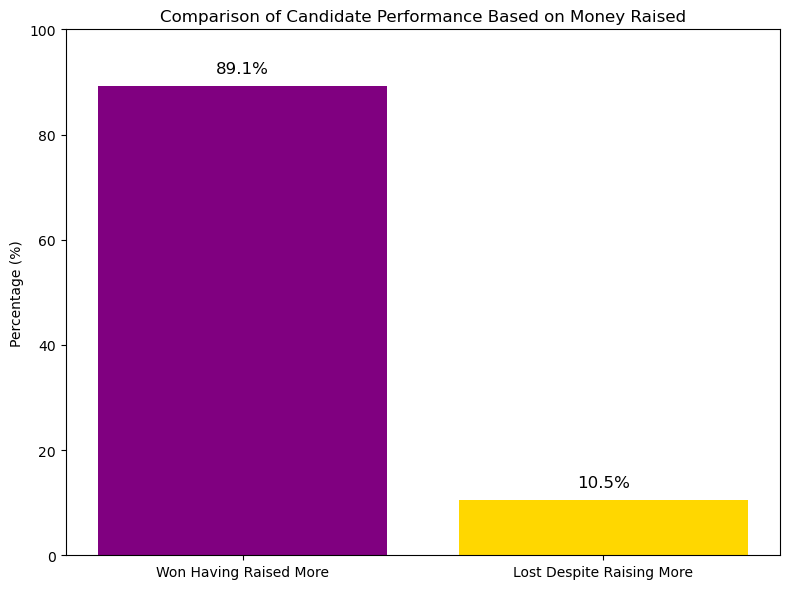

In [15]:
data = {
    'Won Having Raised More': candidate_win_raised_percentage,
    'Lost Despite Raising More': candidate_raised_more_lost_percentage
}

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(data.keys(), data.values(), color=['purple', 'gold'])

ax.set_ylabel('Percentage (%)')
ax.set_title('Comparison of Candidate Performance Based on Money Raised')
ax.set_ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 2, f'{yval:.1f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()

plt.savefig('Money_Raised_percent.png', dpi=150)
plt.show()

b. How often does the candidate who spent more money win a race?

In [17]:
candidate_win_spent_count = 0
for state in df_clean['State'].unique():
    for district in df_clean.loc[df_clean['State'] == state]['District'].unique():
        winners_top_spent = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'W']['Money_Spent'].max()
        losers_top_spent = df_clean.loc[df_clean['State']==state].loc[df_clean['District']==district].loc[df_clean['Result'] == 'L']['Money_Spent'].max()
        if winners_top_spent > max(0, losers_top_spent): #losers_top_spent can be nan, replace with 0
            candidate_win_spent_count += 1
candidate_win_spent_percentage = 100 * candidate_win_spent_count/len(df_clean[df_clean['Result'] == 'W'])
candidate_win_spent_percentage

88.45265588914549

In [18]:
less_spent_win_count = 0

for state in df_clean['State'].unique():
    for district in df_clean.loc[df_clean['State'] == state]['District'].unique():
        
        winner_spent = df_clean.loc[(df_clean['State'] == state) & 
                                    (df_clean['District'] == district) & 
                                    (df_clean['Result'] == 'W')]['Money_Spent'].max()
        loser_spent = df_clean.loc[(df_clean['State'] == state) & 
                                   (df_clean['District'] == district) & 
                                   (df_clean['Result'] == 'L')]['Money_Spent'].max()
        
        if winner_spent < loser_spent:
            less_spent_win_count += 1

total_wins = len(df_clean[df_clean['Result'] == 'W'])
less_spent_win_percentage = 100 * less_spent_win_count / total_wins
less_spent_win_percentage

11.547344110854503

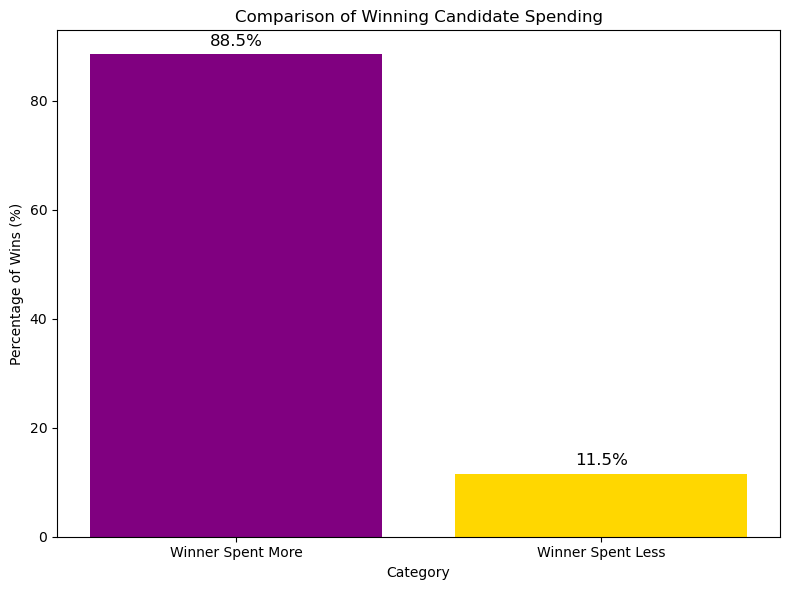

In [19]:
candidate_win_spent_percentage = 100 * candidate_win_spent_count / len(df_clean[df_clean['Result'] == 'W'])
less_spent_win_percentage = 100 * less_spent_win_count / total_wins

percentages = [candidate_win_spent_percentage, less_spent_win_percentage]
categories = ['Winner Spent More', 'Winner Spent Less']

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color=['purple', 'gold'])

plt.title('Comparison of Winning Candidate Spending')
plt.ylabel('Percentage of Wins (%)')
plt.xlabel('Category')

for bar in bars:
    yval = bar.get_height()
    
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=12)

plt.savefig('Money_spent_percent.png', dpi=150)
plt.tight_layout()
plt.show()

 c. Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?

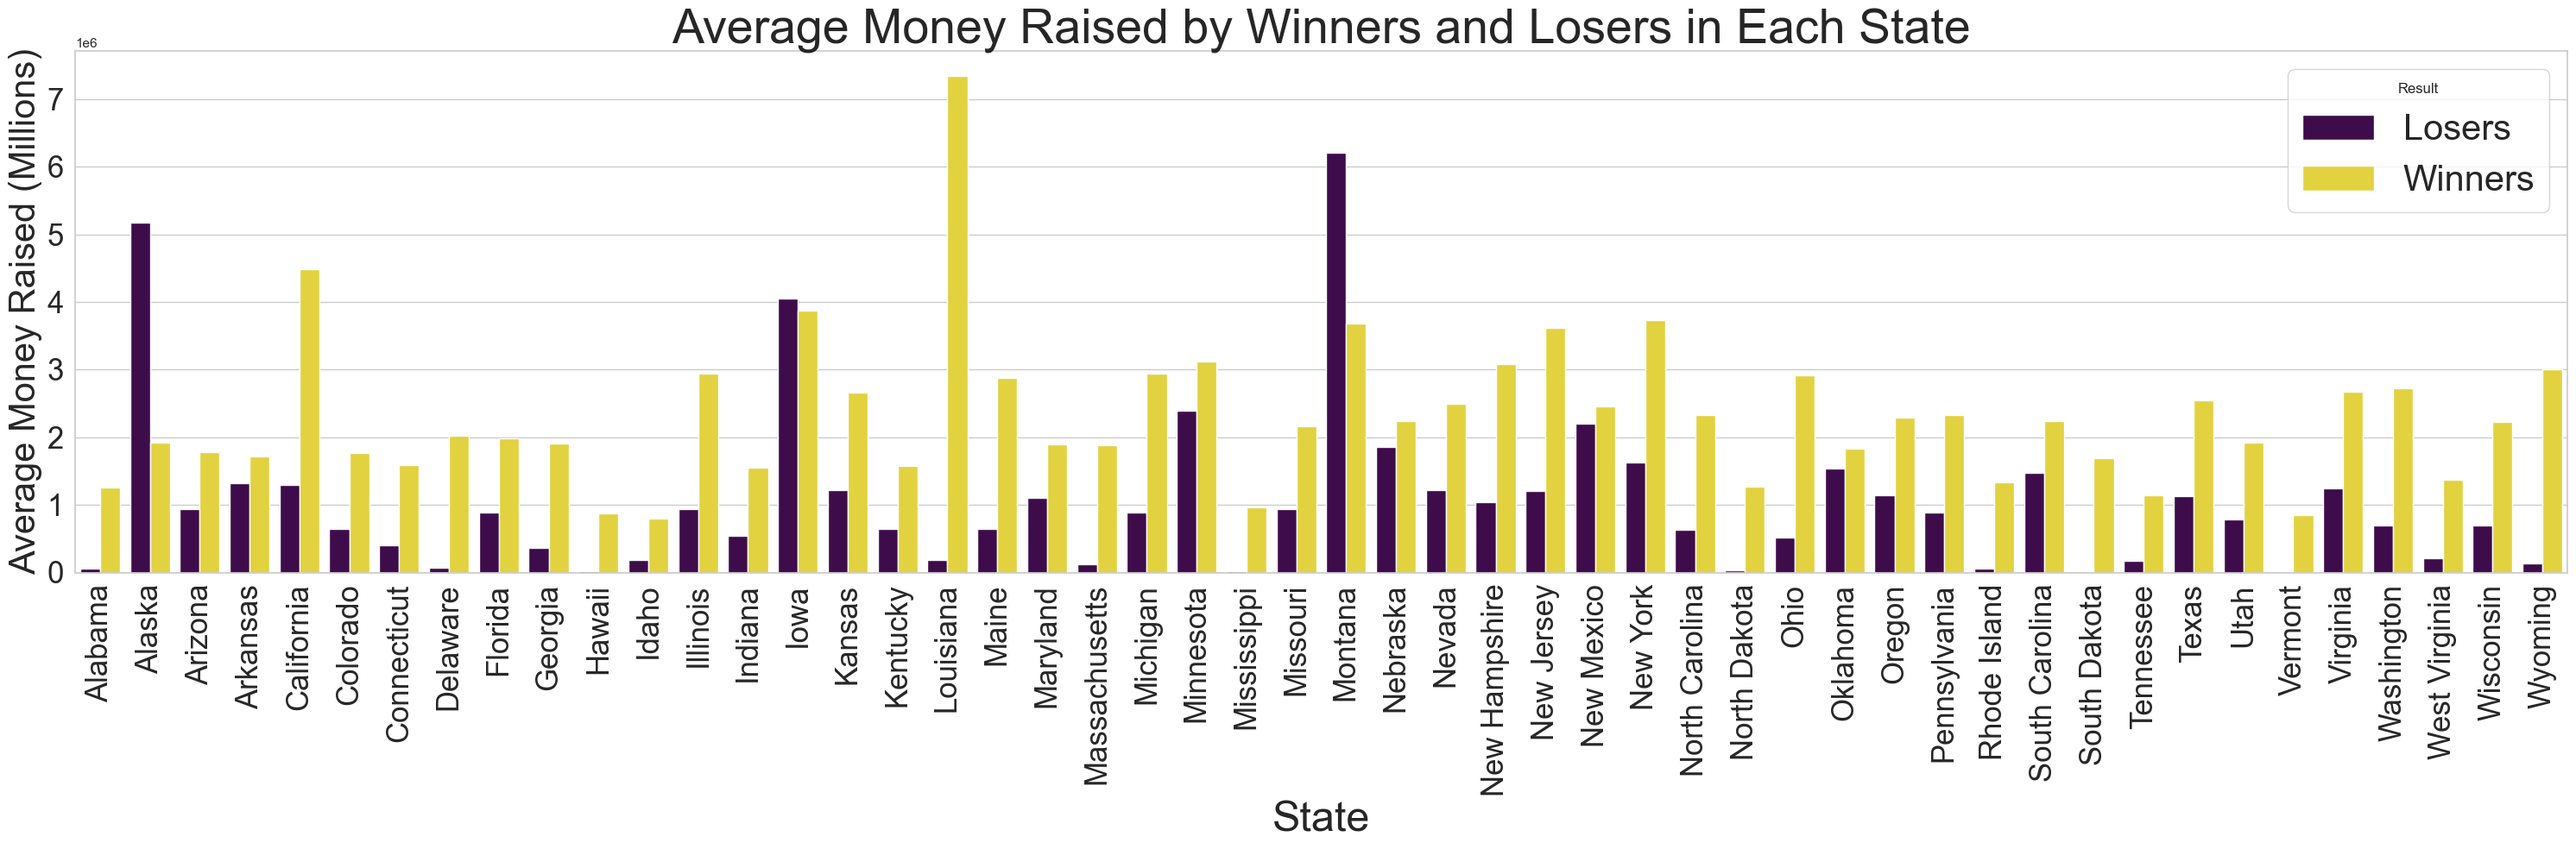

In [21]:
average_df = df_clean.groupby(["State", "Result"], as_index=False)["Money_Raised"].mean()
sns.set(style="whitegrid")
viridis_palette = plt.cm.viridis(np.linspace(0, 1, 2))
viridis_palette = viridis_palette.tolist()

plt.figure(figsize=(30, 10))
bar_plot = sns.barplot(data=average_df, x='State', y='Money_Raised', hue='Result', palette=viridis_palette)

plt.title('Average Money Raised by Winners and Losers in Each State', fontsize=40)
plt.xlabel('State', fontsize=35)
plt.ylabel('Average Money Raised (Millions)', fontsize=30)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
handles, labels = bar_plot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Losers', 'Winners'], title='Result', fontsize=30)
plt.tight_layout()

plt.savefig('avg_money_raised_by_W_L.png', dpi=150)
plt.show()

d. How often does the incumbent candidate win a race?

In [23]:
incumbents = df_clean[df_clean['Candidate_Type'] == 'I']
total_incumbents = incumbents.shape[0]

incumbents_won = incumbents[incumbents['Result'] == 'W'].shape[0]

if total_incumbents > 0:
    win_percentage = (incumbents_won / total_incumbents) * 100
else:
    win_percentage = 0 

print(f"Total Incumbents: {total_incumbents}")
print(f"Incumbents Who Won: {incumbents_won}")
print(f"Incumbent Success Percentage: {win_percentage:.2f}%")

Total Incumbents: 385
Incumbents Who Won: 373
Incumbent Success Percentage: 96.88%


e. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

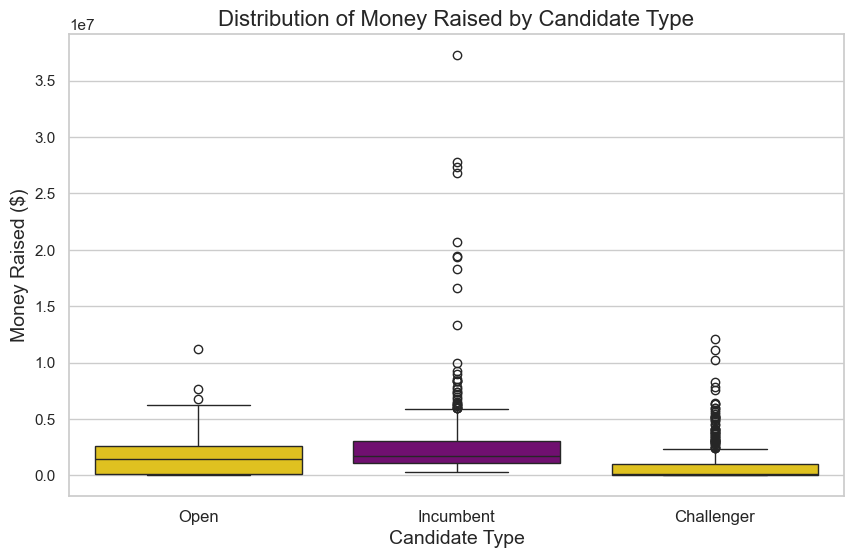

In [25]:
plt.figure(figsize=(10, 6))

custom_palette = {'I': 'purple', 'O': 'gold', 'C': 'gold'}

sns.boxplot(x='Candidate_Type', y='Money_Raised', data=df_clean, hue='Candidate_Type', palette=custom_palette, legend=False)

plt.xticks(
    ticks=[0, 1, 2],
    labels=['Open', 'Incumbent', 'Challenger'],
    fontsize=12
)

plt.xlabel('Candidate Type', fontsize=14) 
plt.ylabel('Money Raised ($)', fontsize=14)  

plt.title('Distribution of Money Raised by Candidate Type', fontsize=16)

plt.savefig('money_raised_by_candidate_type.png', dpi=150)
plt.show()

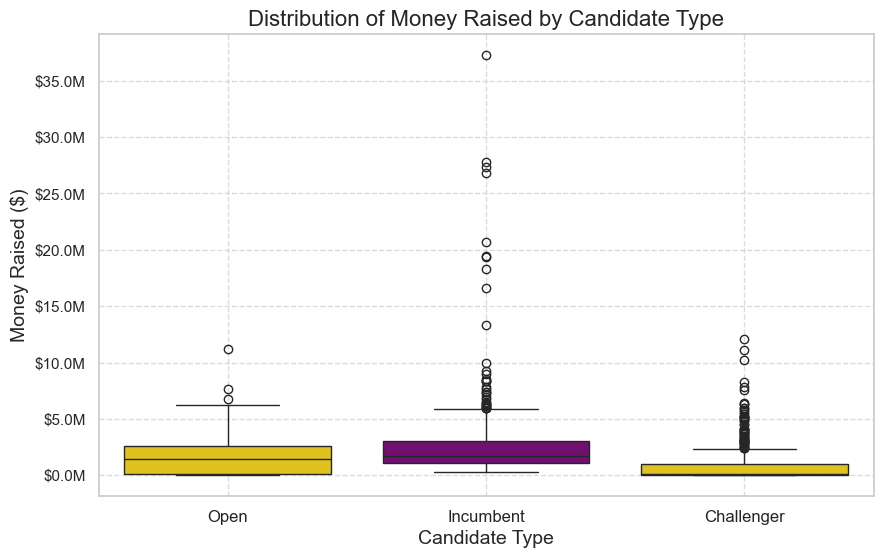

In [26]:
plt.figure(figsize=(10, 6))

custom_palette = {'I': 'purple', 'O': 'gold', 'C': 'gold'}

sns.boxplot(
    x='Candidate_Type', 
    y='Money_Raised', 
    data=df_clean, 
    hue='Candidate_Type', 
    palette=custom_palette, 
)

plt.xticks(
    ticks=[0, 1, 2],
    labels=['Open', 'Incumbent', 'Challenger'],
    fontsize=12
)

plt.xlabel('Candidate Type', fontsize=14)
plt.ylabel('Money Raised ($)', fontsize=14)

plt.title('Distribution of Money Raised by Candidate Type', fontsize=16)


plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('money_raised_by_candidate_type_millions.png', dpi=300)
plt.show()

In [27]:
incumbents = df_clean[df_clean['Candidate_Type'] == 'I']
open = df_clean[df_clean['Candidate_Type'] == 'O']
challenger = df_clean[df_clean['Candidate_Type'] == 'C']

incumbents_money = incumbents['Money_Raised']
open_money = open['Money_Raised']
challenger_money = challenger['Money_Raised']

incumbents_money.describe(), open_money.describe(), challenger_money.describe()

(count    3.850000e+02
 mean     2.813123e+06
 std      3.861846e+06
 min      3.277270e+05
 25%      1.071961e+06
 50%      1.700061e+06
 75%      3.003883e+06
 max      3.726283e+07
 Name: Money_Raised, dtype: float64,
 count    1.090000e+02
 mean     1.740476e+06
 std      1.970974e+06
 min      0.000000e+00
 25%      1.284580e+05
 50%      1.418014e+06
 75%      2.595446e+06
 max      1.123967e+07
 Name: Money_Raised, dtype: float64,
 count    3.980000e+02
 mean     9.195963e+05
 std      1.760100e+06
 min      0.000000e+00
 25%      2.442241e+04
 50%      1.105414e+05
 75%      9.560108e+05
 max      1.205056e+07
 Name: Money_Raised, dtype: float64)

In [28]:
challenger_negative_money = challenger[challenger['Money_Raised'] == 0]

print(challenger_negative_money)

            cid           FirstLastP  Money_Raised  Money_Spent  EndCash  \
55    N00045123     Scott Giblin (R)           0.0       593.86     0.00   
75    N00045124    Alison Hayden (R)           0.0      8357.65  5727.32   
253   N00045680  Theodore Murray (I)           0.0        10.00   499.00   
256   N00047454      K.W. Miller (3)           0.0         0.00   100.00   
823   N00047555  Theresa Everett (I)           0.0         0.00  6873.15   
891   N00043366  Richie Castaldo (L)           0.0      1425.00     0.00   
1039  N00046292      Shawn Kelly (L)           0.0         0.00     0.00   
1092  N00038289       Tom Wakely (3)           0.0         0.00     0.00   
1111  N00045168       Jay Taylor (I)           0.0         0.00     0.00   
1197  N00033103     Andrew Straw (3)           0.0         0.00     0.00   

      LgIndivs  SmIndivs  VotePercent Result Candidate_Type           State  \
55         0.0       0.0        23.20      L              C      California   
75   

Incumbents, on average, raised the most amount of money clocking in at an average of $2.8M raised. Open candidates followed behind with an average of $1.25M and lastly, challenger candidates with $508K. 

Incumbents vary more in the amount of money raised and have the highest std deviation. 



### Part 3: Statistical Modeling
Fit a logistic regression model to see if the amount spent has a statistically significant impact on the probability of winning an election.  
Feel free to brainstorm ways to set up your model, but a suggestion to get started would be to calculate, for each candidate, the percentage of to total amount spent in their race that was spent by them and use this as your predictor variable of interest. Hint: you may find the `transform` method (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html) in combination with `groupby` useful to find the total spending by race.  
Don't forget to include the incumbent variable in your model.  
After fitting your model, interpret the meaning of the coefficients you get.  

In [31]:
df_clean['Total_Spent_By_District'] = df_clean.groupby(['State_Abv', 'District'])['Money_Spent'].transform('sum')
df_clean['Proportion_Spent_By_Candidate'] = df_clean['Money_Spent'] / df_clean['Total_Spent_By_District']
df_clean['Percentage_Spent_By_Candidate'] = df_clean['Proportion_Spent_By_Candidate'].map('{:.2%}'.format)

In [32]:
pd.set_option('future.no_silent_downcasting', True)
df_clean['Result'] = df_clean['Result'].replace(['L', 'l'], 0)

df_clean['Result'] = df_clean['Result'].replace(['W', 'w'], 1)

df_clean['Result'] = pd.to_numeric(df_clean['Result'])

In [33]:
result_spent_percentage_logreg = smf.logit("Result ~ Proportion_Spent_By_Candidate",
                          data = df_clean).fit()

result_candidate_spent_percentage_logreg = smf.logit("Result ~ Proportion_Spent_By_Candidate + Candidate_Type",
                          data = df_clean).fit()
def logistic(x):
    return 1 / (1 + np.exp(-x))

Optimization terminated successfully.
         Current function value: 0.233919
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.154333
         Iterations 8


In [34]:
result_spent_percentage_logreg.params

Intercept                       -4.544551
Proportion_Spent_By_Candidate    9.078641
dtype: float64

In [35]:
result_candidate_spent_percentage_logreg.params

Intercept                       -4.862886
Candidate_Type[T.I]              4.532409
Candidate_Type[T.O]              2.166264
Proportion_Spent_By_Candidate    5.189496
dtype: float64